In [189]:
import pandas as pd
import numpy as np
import pickle


import re
import nltk
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, model_from_json

import tensorflow as tf
from tensorflow import keras
 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshvasilvasstar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [172]:
df = pd.read_csv('model_training.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5125 entries, 0 to 5124
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  5125 non-null   object
 1   topic     5125 non-null   object
dtypes: object(2)
memory usage: 80.2+ KB


In [195]:
data = pd.read_excel('responses.xlsx',engine='openpyxl')
# Create a dictionary from columns A and B
intent_dict = dict(zip(data['intent'], data['dialog']))
# Save the dictionary to a pickle file
with open('intent_dict.pkl', 'wb') as file:
    pickle.dump(intent_dict, file)

intent_dict_es = dict(zip(data['intent'], data['dialog_es']))
# Save the dictionary to a pickle file
with open('intent_dict_es.pkl', 'wb') as file:
    pickle.dump(intent_dict_es, file)

In [173]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    # text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['question'] = df['question'].apply(clean_text)
df['question'] = df['question'].str.replace('\d+', '')

In [174]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 125
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['question'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3009 unique tokens.


In [175]:
X = tokenizer.texts_to_sequences(df['question'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5125, 125)


In [176]:
with open('tokenizer.pkl', 'wb') as token_file:
    pickle.dump(tokenizer, token_file)

In [177]:
Y = pd.get_dummies(df['topic']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5125, 245)


In [178]:
temp_df = pd.get_dummies(df['topic'])
temp_df.head()

,am_i_eligible_to_be_screened_for_diabetes,am_i_eligible_to_be_screened_for_high_blood_pressure,am_i_eligible_to_get_my_cholesterol_screened,am_i_eligible_to_get_screened_for_diabetes_and_high_blood_pressure,am_i_eligible_to_get_screened_for_diabetes_and_high_cholesterol,am_i_eligible_to_get_screened_for_diabetes_high_blood_pressure_and_high_cholesterol,am_i_eligible_to_get_screened_for_high_blood_pressure_and_high_cholesterol,am_i_eligible_to_get_the_hpv_vaccine,are_there_cancer_support_groups_that_are_for_the_latino_community,are_there_differences_in_who_gets_breast_cancer,...,why_should_i_eat_healthy,why_should_i_get_screened_for_diabetes,why_should_i_get_screened_for_diabetes_and_high_blood_pressure,why_should_i_get_screened_for_diabetes_and_high_cholesterol,why_should_i_get_screened_for_diabetes_high_blood_pressure_and_high_cholesterol,why_should_i_get_screened_for_high_blood_pressure,why_should_i_get_screened_for_high_blood_pressure_and_high_cholesterol,why_should_i_get_screened_for_high_cholesterol,why_should_i_set_physical_activity_goals,why_should_i_take_the_medications_im_prescribed
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [179]:
reverse_mapping_dict = {i:col for i, col in enumerate(temp_df.columns)}
# Save the reverse mapping dictionary to a pickle file
with open('reverse_mapping.pkl', 'wb') as file:
    pickle.dump(reverse_mapping_dict, file)

In [180]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4612, 125) (4612, 245)
(513, 125) (513, 245)


In [181]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
model = keras.Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(245, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 40

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
104/104 [==============================] - 16s 146ms/step - loss: 5.4852 - accuracy: 0.0212 - val_loss: 5.4305 - val_accuracy: 0.0390
Epoch 2/100
104/104 [==============================] - 15s 149ms/step - loss: 5.0676 - accuracy: 0.0308 - val_loss: 4.6980 - val_accuracy: 0.0390
Epoch 3/100
104/104 [==============================] - 15s 147ms/step - loss: 4.1071 - accuracy: 0.1181 - val_loss: 3.7725 - val_accuracy: 0.1494
Epoch 4/100
104/104 [==============================] - 15s 149ms/step - loss: 3.2267 - accuracy: 0.2711 - val_loss: 3.0814 - val_accuracy: 0.2814
Epoch 5/100
104/104 [==============================] - 15s 146ms/step - loss: 2.5702 - accuracy: 0.4243 - val_loss: 2.6303 - val_accuracy: 0.3723
Epoch 6/100
104/104 [==============================] - 15s 144ms/step - loss: 2.0692 - accuracy: 0.5610 - val_loss: 2.3761 - val_accuracy: 0.3766
Epoch 7/100
104/104 [==============================] - 15s 147ms/step - loss: 1.7082 - accuracy: 0.6407 - val_loss: 2.1314 -

In [186]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

17/17 [==============================] - 0s 21ms/step - loss: 1.6484 - accuracy: 0.5478
Test set
  Loss: 1.648
  Accuracy: 0.548


MAX_SEQUENCE_LENGTH = 64 -> accuracy=0.569

MAX_SEQUENCE_LENGTH = 125 -> accuracy=0.575

MAX_SEQUENCE_LENGTH = 250 -> accuracy=0.54

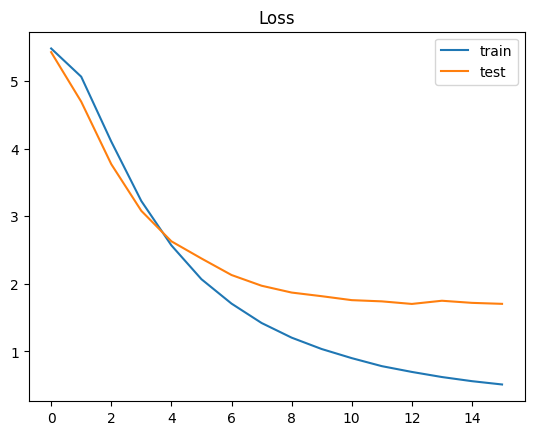

In [183]:
from matplotlib import pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

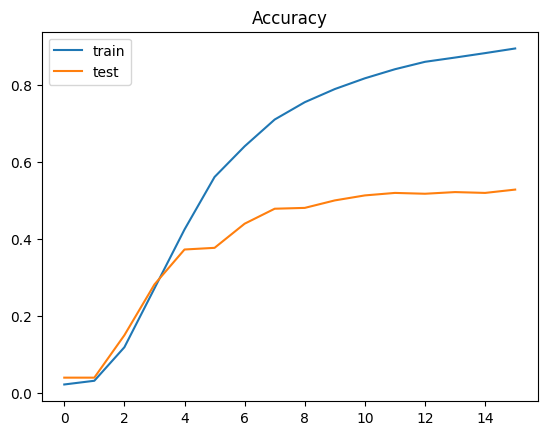

In [184]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [187]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [190]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [185]:
# Save the trained model
model.save('topic_classification_model.keras')
model.save('topic_classification_model.h5')

/Users/joshvasilvasstar/Documents/clinicchat/tepeyac_chatbot/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [135]:
# Load the model for prediction
loaded_model = keras.models.load_model('topic_classification_model.h5')

In [191]:
new_complaint = ['why should i screen for diabetes']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = loaded_model.predict(padded)[0]
top_topic_indices = np.argsort(pred)[::-1][:4]
labels = df['topic'].unique()
# print(pred, labels[np.argmax(pred)])
# Print the top 4 predicted topics and their probabilities
for idx in top_topic_indices:
    topic_label = reverse_mapping_dict[idx]
    probability = pred[idx]
    print("Topic:", topic_label, "Probability:", probability)

1/1 [==============================] - 0s 133ms/step
Topic: how_can_i_prevent_diabetes Probability: 0.35229325
Topic: why_should_i_get_screened_for_diabetes Probability: 0.07603625
Topic: what_is_involved_in_screening_for_diabetes Probability: 0.07055103
Topic: how_does_vaccination_prevent_diabetes_complications Probability: 0.06846282
